# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234925 sha256=d9f1124956143f746300ca459d61755dc764cd8708d71f4386f69e690e7bfc8a
  Stored in directory: /Users/christophergarcia/Library/Caches/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [38]:
# Add any additional import statements you need here
import re
import shutil
import random
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [39]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [40]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/christophergarcia/Desktop/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics"

In [65]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """

    
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len(''.join(tokens))
    
    if verbose:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        counts = Counter(tokens)
        
        if num_tokens > 0:
            print(counts.most_common(num_tokens))
        
            
            
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [66]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
[('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1), ('with', 1), ('other', 1), ('in', 1), ('this', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: One reason for using assertion in statments is to keep code clean and reduce the chances of errors.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [67]:
# Read in the lyrics data
lyrics_data = defaultdict(dict)

for item in os.listdir(data_location + lyrics_folder):
    if os.path.isdir(data_location + lyrics_folder + item):
        for lyric_page in os.listdir(data_location + lyrics_folder + item):
            artist, song = lyric_page.split('_')
            song = song.replace('.txt', '')
            lyrics_data[item][song] = open(data_location + lyrics_folder + item)


In [68]:
# Read in the twitter data
twitter_file = os.listdir(data_location + twitter_folder)
desc_files = [f for f in twitter_file if "followers_data" in f]
twitter_data = defaultdict(list)

for f in desc_files:
    artist = f.split('_')[0]
    
    with open(data_location + twitter_folder + f, 'r', encoding='utf8') as infile:
        next(infile)
        for idx, line in enumerate(infile.readlines()):
            line = line.strip('\t')
            if len(line) == 7:
                twitter_data[artist].append(line[6])

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [69]:
punctuation = set(punctuation) # speeds up comparison

In [75]:
# create your clean twitter data here
twitter_processed = defaultdict(list)

for artist in twitter_data:
    descriptions = ''.join(twitter_data[artist])
    
    # Remove punctuation
    descriptions = ''.join([ch for ch in descriptions if ch not in punctuation])
    
    descriptions = [item.lower().strip for item in descriptions.split()]
    
    descriptions = [item for item in descriptions if item not in sw]
    twitter_processed[artist].extend(descriptions)

In [71]:
# create your clean lyrics data here
lyrics_processed = defaultdict(list)

for artists in lyrics_data:
    for song in lyrics_data[artist]:
        
        # Remove punctuation
        lyrics = ''.join([ch for ch in lyrics_data[artist][song] if ch in punctuation])
        
        # Strip whitespace
        lyrics = [item.lower().strip for item in lyrics.split()]
        
        # Remove stopwords
        lyrics = [item for item in lyrics if item not in sw]
        lyrics_processed[artist].extend(lyrics)
        

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [73]:
# calls to descriptive_stats here
#descriptive_stats(lyrics_processed['robyn'], num_tokens=10)
#descriptive_stats(lyrics_processed['cher'], num_tokens=10)
# GETTING DIVISION BY ZERO ERROR

In [79]:
#descriptive_stats(twitter_processed['robyn'], num_tokens=10)
#descriptive_stats(lyrics_processed['cher'], num_tokens=10)
# ANOTHER DIVISION BY ZERO ERROR

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: 



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [80]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [85]:
# Your code here
emojis = defaultdict(list)

for artist in twitter_data:
    for desc in twitter_data[artist]:
        emojis[artist].extend([ch for ch in desc if emoji.is_emoji(ch)])
        
for artist in emojis:
    print(artist)
    print(Counter(emojis[artist]).most_common(10))

### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [88]:
# Your code here
hashtags = defaultdict(list)

for artist in twitter_data:
    for desc in twitter_data[artist]:
        
        hashtags[artist].extend([item.lower() for item in desc.split()])
        
# Display hashtags
for artist in hashtags:
    print(artist)
    print(Counter(hashtags[artist]).most_common(10))

### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [89]:
# Your code here

### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

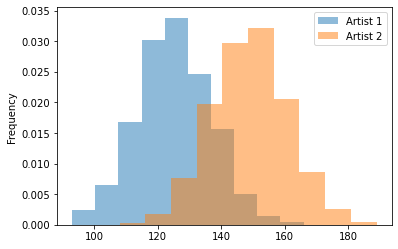

In [90]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The wildcard '\s+' is used to match onto whitespaces in text data.


In [91]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

In [92]:
# Your lyric length comparison chart here. 